# Test MDRNN Training by Overfitting on One Example

In this notebook, we will try to train the MDRNN on a single example to see if we can get it to overfit. 

Hopefully we can debug the model a bit this way.

### First Import the Model and Tensorflow

In [5]:
import keras
from keras import backend as K
import numpy as np
import tensorflow as tf
import random
from context import * # imports robojam
import os

import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Set up environment.                                                                                                                                                                                 
# Only for GPU use:                                                                                                                                                                                   
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

In [ ]:
# Plots and Functions for diff'ed data. Unused right now.

# def divide_performance_into_swipes(perf_df):
#     """Divides a performance into a sequence of swipe dataframes for plotting."""
#     touch_starts = perf_df[perf_df.moving == 0].index
#     performance_swipes = []
#     remainder = perf_df
#     for att in touch_starts:
#         swipe = remainder.iloc[remainder.index < att]
#         performance_swipes.append(swipe)
#         remainder = remainder.iloc[remainder.index >= att]
#     performance_swipes.append(remainder)
#     return performance_swipes

# def plot_2D(perf_df, name="foo", saving=False):
#     """Plot a 2D representation of a performance 2D"""
#     swipes = divide_performance_into_swipes(perf_df)
#     plt.figure(figsize=(8, 8))
#     for swipe in swipes:
#         p = plt.plot(swipe.x, swipe.y, 'o-')
#         plt.setp(p, color=gen_colour, linewidth=5.0)
#     plt.ylim(1.0,0)
#     plt.xlim(0,1.0)
#     plt.xticks([])
#     plt.yticks([])
#     if saving:
#         plt.savefig(name+".png", bbox_inches='tight')
#         plt.close()
#     else:
#         plt.show()

# def generate_performance(net, first_touch, number, sess, temp=1.0):
#     """Special version of generate performance for sampling during training."""
#     previous_touch = np.array([0, 0, first_touch[2]])
#     # np.array([np.random.rand(), np.random.rand(), 0.01])
#     performance = [previous_touch.reshape((net.n_input_units,))]
#     for i in range(number):
#         previous_touch = net.generate_touch(previous_touch, sess, temp=temp)
#         performance.append(previous_touch.reshape((net.n_input_units,)))
#     generated = np.array(performance)
#     summed = diff_to_normal_perf(generated, first_touch) # convert to normal performance format.
#     return summed

# def diff_to_normal_perf(perf, first_touch):
#     """Adds up XY points in a differential performance to produce a normal one. Operates on ndarrays."""
#     first_xy = first_touch[[0,1]]
#     t = perf.T[2]
#     xy = perf.T[[0,1]]
#     xy_summed = (np.cumsum(xy, axis=1) + (np.ones((257,2)) * first_xy).T)
#     return np.append(xy_summed, np.array([t]), axis=0).T

# def normal_to_diff_perf(perf):
#     """Diffs the XY columns in a normal performance to produce a differential one. Operates on ndarrays."""
#     t = perf.T[2]
#     xy = perf.T[[0,1]]
#     xy_diff = np.diff(xy)
#     xy_diff = np.insert(xy_diff, 0, [0,0], axis=1)
#     return np.append(xy_diff, np.array([t]), axis=0).T 

In [ ]:
# # Testing diff'ed performance converters.
# diffed = normal_to_diff_perf(overfit_datum)
# summed = diff_to_normal_perf(diffed, start_point)

# plot_2D(robojam.perf_array_to_df(overfit_datum))
# plot_2D(robojam.perf_array_to_df(summed))

In [13]:
# Training Hyperparameters:
SEQ_LEN = 256
HIDDEN_UNITS = 256
N_LAYERS = 2
NUMBER_MIXTURES = 5
TIME_DIST = True

BATCH_SIZE = 1
EPOCHS = 1000
VAL_SPLIT = 0.0

SEED = 2345
random.seed(SEED)
np.random.seed(SEED)
# tf.set_random_seed(5791)  # only works for current graph.

Loaded perfs: 1626 and 1626
Num touches: 249870
Corpus Examples: 270
Number of training examples:
X: (41885, 256, 3)
y: (41885, 256, 3)


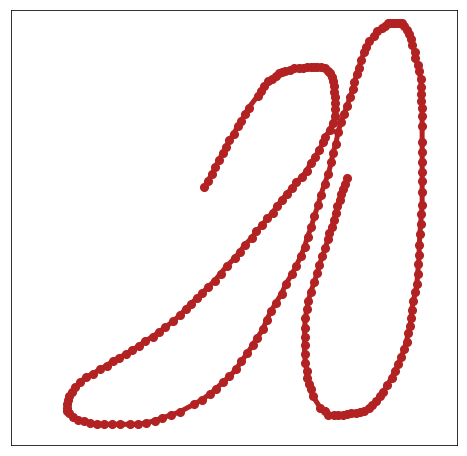

In [52]:
# Load tiny performance data:                                                                                                                                                                         
with np.load('../datasets/tiny_performance_datasets.npz') as loaded:
    loaded_raw = loaded['raw_perfs']
    loaded_diff = loaded['diff_perfs']

print("Loaded perfs:", len(loaded_raw), "and", len(loaded_diff))
print("Num touches:", np.sum([len(l) for l in loaded_raw]))

corpus = []

for l in loaded_raw:
    corpus.append(l[:,:-1])

# Restrict corpus to sequences longer than the corpus.                                                                                                                                                
corpus = [l for l in corpus if len(l) > SEQ_LEN+1]
print("Corpus Examples:", len(corpus))

# Prepare training data as X and Y.                                                                                                                                                                   
slices = []
for seq in corpus:
    slices += robojam.slice_sequence_examples(seq, SEQ_LEN+1)

X, y = robojam.seq_to_overlapping_format(slices)

X = np.array(X) * robojam.SCALE_FACTOR
y = np.array(y) * robojam.SCALE_FACTOR

print("Number of training examples:")
print("X:", X.shape)
print("y:", y.shape)

example = 1500
overfit_X = X[example]  # picked a sample
overfit_y = y[example]
overfit_start_point = overfit_X[0] / robojam.SCALE_FACTOR

## Let's have a look at the example to overfit on.
robojam.plot_2D(robojam.perf_array_to_df(overfit_X / robojam.SCALE_FACTOR))

In [47]:
# model_name
model_name = "overfit-model" + "-layers" + str(N_LAYERS) + "-units" + str(HIDDEN_UNITS) + "-mixtures" + str(NUMBER_MIXTURES) + "-scale" + str(robojam.SCALE_FACTOR)
print("Training: ", model_name)


# Setup Training Model                                                                                                                                                                                
model = robojam.build_robojam_model(seq_len=SEQ_LEN, hidden_units=HIDDEN_UNITS, num_mixtures=NUMBER_MIXTURES, layers=2, time_dist=TIME_DIST, inference=False, compile_model=True, print_summary=True)



# Setup callbacks                                                                                                                                                                                     
filepath = model_name + "-E{epoch:02d}-VL{loss:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
terminateOnNaN = keras.callbacks.TerminateOnNaN()
tboard = keras.callbacks.TensorBoard(log_dir='./logs/'+model_name, histogram_freq=0, batch_size=32, write_graph=True, update_freq='epoch')

# Train                                                                                                                                                                                               
history = model.fit(np.array([overfit_X]), np.array([overfit_y]), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[checkpoint, terminateOnNaN, tboard])
#history = model.fit_generator(generator, steps_per_epoch=300, epochs=100, verbose=1, initial_epoch=0)                                                                                                

Training:  overfit-model-layers2-units256-mixtures5-scale10
Building RoboJam Model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 256, 3)            0         
_________________________________________________________________
lstm0 (LSTM)                 (None, 256, 256)          266240    
_________________________________________________________________
lstm1 (LSTM)                 (None, 256, 256)          525312    
_________________________________________________________________
td_mdn (TimeDistributed)     (None, 256, 35)           8995      
Total params: 800,547
Trainable params: 800,547
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 38.8895

Epoch 00001: loss improved from inf to 38.88949, saving model to overfit-model-layers2-units256-mixtur


Epoch 00046: loss did not improve from 3.63817
Epoch 47/1000
1/1 [==============================] - 0s 143ms/step - loss: 3.6170

Epoch 00047: loss improved from 3.63817 to 3.61696, saving model to overfit-model-layers2-units256-mixtures5-scale10-E47-VL3.62.hdf5
Epoch 48/1000
1/1 [==============================] - 0s 142ms/step - loss: 3.3866

Epoch 00048: loss improved from 3.61696 to 3.38658, saving model to overfit-model-layers2-units256-mixtures5-scale10-E48-VL3.39.hdf5
Epoch 49/1000
1/1 [==============================] - 0s 142ms/step - loss: 3.2319

Epoch 00049: loss improved from 3.38658 to 3.23186, saving model to overfit-model-layers2-units256-mixtures5-scale10-E49-VL3.23.hdf5
Epoch 50/1000
1/1 [==============================] - 0s 142ms/step - loss: 3.1356

Epoch 00050: loss improved from 3.23186 to 3.13556, saving model to overfit-model-layers2-units256-mixtures5-scale10-E50-VL3.14.hdf5
Epoch 51/1000
1/1 [==============================] - 0s 143ms/step - loss: 3.1429

Epoch

1/1 [==============================] - 0s 143ms/step - loss: 5.0964

Epoch 00104: loss did not improve from 2.67394
Epoch 105/1000
1/1 [==============================] - 0s 142ms/step - loss: 5.1085

Epoch 00105: loss did not improve from 2.67394
Epoch 106/1000
1/1 [==============================] - 0s 143ms/step - loss: 5.0363

Epoch 00106: loss did not improve from 2.67394
Epoch 107/1000
1/1 [==============================] - 0s 142ms/step - loss: 4.9903

Epoch 00107: loss did not improve from 2.67394
Epoch 108/1000
1/1 [==============================] - 0s 142ms/step - loss: 4.9883

Epoch 00108: loss did not improve from 2.67394
Epoch 109/1000
1/1 [==============================] - 0s 143ms/step - loss: 5.0172

Epoch 00109: loss did not improve from 2.67394
Epoch 110/1000
1/1 [==============================] - 0s 142ms/step - loss: 5.0610

Epoch 00110: loss did not improve from 2.67394
Epoch 111/1000
1/1 [==============================] - 0s 143ms/step - loss: 5.1078

Epoch 00111: l

1/1 [==============================] - 0s 142ms/step - loss: 3.8713

Epoch 00160: loss did not improve from 1.42527
Epoch 161/1000
1/1 [==============================] - 0s 143ms/step - loss: 2.3946

Epoch 00161: loss did not improve from 1.42527
Epoch 162/1000
1/1 [==============================] - 0s 143ms/step - loss: 2.1154

Epoch 00162: loss did not improve from 1.42527
Epoch 163/1000
1/1 [==============================] - 0s 143ms/step - loss: 2.9098

Epoch 00163: loss did not improve from 1.42527
Epoch 164/1000
1/1 [==============================] - 0s 144ms/step - loss: 2.3327

Epoch 00164: loss did not improve from 1.42527
Epoch 165/1000
1/1 [==============================] - 0s 143ms/step - loss: 1.8272

Epoch 00165: loss did not improve from 1.42527
Epoch 166/1000
1/1 [==============================] - 0s 146ms/step - loss: 2.0218

Epoch 00166: loss did not improve from 1.42527
Epoch 167/1000
1/1 [==============================] - 0s 148ms/step - loss: 2.2409

Epoch 00167: l

1/1 [==============================] - 0s 143ms/step - loss: 4.9445

Epoch 00211: loss did not improve from -1.05684
Epoch 212/1000
1/1 [==============================] - 0s 143ms/step - loss: 3.1186

Epoch 00212: loss did not improve from -1.05684
Epoch 213/1000
1/1 [==============================] - 0s 142ms/step - loss: 2.3871

Epoch 00213: loss did not improve from -1.05684
Epoch 214/1000
1/1 [==============================] - 0s 145ms/step - loss: 3.3728

Epoch 00214: loss did not improve from -1.05684
Epoch 215/1000
1/1 [==============================] - 0s 144ms/step - loss: 2.9858

Epoch 00215: loss did not improve from -1.05684
Epoch 216/1000
1/1 [==============================] - 0s 143ms/step - loss: 2.6525

Epoch 00216: loss did not improve from -1.05684
Epoch 217/1000
1/1 [==============================] - 0s 144ms/step - loss: 2.5023

Epoch 00217: loss did not improve from -1.05684
Epoch 218/1000
1/1 [==============================] - 0s 144ms/step - loss: 2.5238

Epoch 0


Epoch 00270: loss did not improve from -1.71167
Epoch 271/1000
1/1 [==============================] - 0s 143ms/step - loss: -2.3723

Epoch 00271: loss improved from -1.71167 to -2.37226, saving model to overfit-model-layers2-units256-mixtures5-scale10-E271-VL-2.37.hdf5
Epoch 272/1000
1/1 [==============================] - 0s 149ms/step - loss: -0.1412

Epoch 00272: loss did not improve from -2.37226
Epoch 273/1000
1/1 [==============================] - 0s 144ms/step - loss: 7.2924

Epoch 00273: loss did not improve from -2.37226
Epoch 274/1000
1/1 [==============================] - 0s 143ms/step - loss: 4.3859

Epoch 00274: loss did not improve from -2.37226
Epoch 275/1000
1/1 [==============================] - 0s 143ms/step - loss: 0.4922

Epoch 00275: loss did not improve from -2.37226
Epoch 276/1000
1/1 [==============================] - 0s 143ms/step - loss: -1.1965

Epoch 00276: loss did not improve from -2.37226
Epoch 277/1000
1/1 [==============================] - 0s 143ms/step

1/1 [==============================] - 0s 142ms/step - loss: 1.6732

Epoch 00332: loss did not improve from -2.37226
Epoch 333/1000
1/1 [==============================] - 0s 144ms/step - loss: 1.7013

Epoch 00333: loss did not improve from -2.37226
Epoch 334/1000
1/1 [==============================] - 0s 143ms/step - loss: 1.6867

Epoch 00334: loss did not improve from -2.37226
Epoch 335/1000
1/1 [==============================] - 0s 143ms/step - loss: 1.5391

Epoch 00335: loss did not improve from -2.37226
Epoch 336/1000
1/1 [==============================] - 0s 143ms/step - loss: 1.4359

Epoch 00336: loss did not improve from -2.37226
Epoch 337/1000
1/1 [==============================] - 0s 144ms/step - loss: 1.4410

Epoch 00337: loss did not improve from -2.37226
Epoch 338/1000
1/1 [==============================] - 0s 150ms/step - loss: 1.3548

Epoch 00338: loss did not improve from -2.37226
Epoch 339/1000
1/1 [==============================] - 0s 144ms/step - loss: 1.1938

Epoch 0

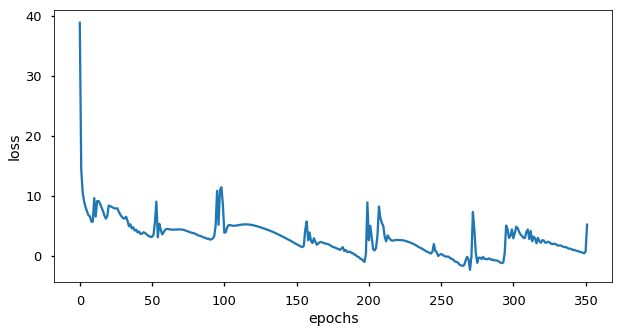

In [49]:
#Plot the loss                                                                                                                                                                                       
%matplotlib inline                                                                                                                                                                                  
plt.figure(figsize=(10, 5))                                                                                                                                                                         
plt.plot(history.history['loss'])                                                                                                                                                                   
#plt.plot(history.history['val_loss'])                                                                                                                                                               
plt.xlabel("epochs")                                                                                                                                                                                
plt.ylabel("loss")                                                                                                                                                                                  
plt.show()  

In [51]:
# Deocoding model:
model_to_load = "overfit-model-layers2-units256-mixtures5-scale10-E271-VL-2.37.hdf5"
decoder = robojam.load_robojam_inference_model(model_file=model_to_load, layers=N_LAYERS, units=HIDDEN_UNITS, mixtures=NUMBER_MIXTURES)

#decoder = robojam.(seq_len=SEQ_LEN, hidden_units=HIDDEN_UNITS, num_mixtures=NUMBER_MIXTURES, layers=N_LAYERS, time_dist=TIME_DIST, inference=True, compile_model=False, print_summary=True)
#decoder.load_weights("../robojam-model-layers2-units512-mixtures5-scale10-E13-VL-5.79.hdf5")
#decoder.load_weights("../models/robojam-metatone-layers2-units512-mixtures5-scale10-E30-VL-5.65.hdf5")

Building RoboJam Model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (1, 1, 3)                 0         
_________________________________________________________________
lstm0 (LSTM)                 (1, 1, 256)               266240    
_________________________________________________________________
lstm1 (LSTM)                 (1, 256)                  525312    
_________________________________________________________________
mdn_outputs (MDN)            (1, 35)                   8995      
Total params: 800,547
Trainable params: 800,547
Non-trainable params: 0
_________________________________________________________________


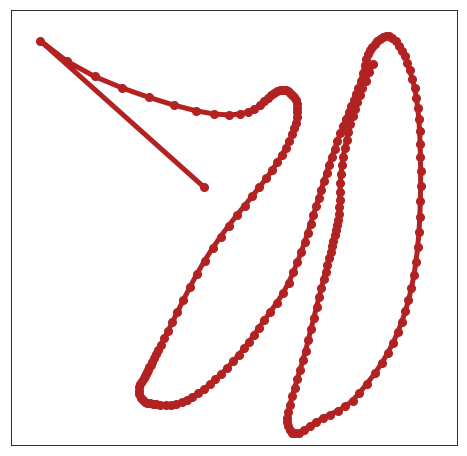

In [80]:
decoder.reset_states()
mixture_temp = 0.1
sigma_temp = 0.
t = overfit_start_point
p = robojam.generate_random_tiny_performance(decoder, NUMBER_MIXTURES, t, temp=mixture_temp, sigma_temp=sigma_temp)
robojam.plot_2D(robojam.perf_array_to_df(p))

#plot_3D(robojam.perf_array_to_df(p))